# Exercise 07.01

## Problem:

**[Purpose: To explore the autocorrelation function in Figure 7.12.]**

At the end of the script BernMetrop.R, add these lines:

    openGraph(height=7,width=3.5)
    layout(matrix(1:2,nrow=2))
    acf( acceptedTraj , lag.max=30 , col="skyblue" , lwd=3 )
    Len = length( acceptedTraj )
    Lag = 10
    trajHead = acceptedTraj[ 1 : (Len-Lag) ]
    trajTail = acceptedTraj[ (1+Lag) : Len ]
    plot( trajHead , trajTail , pch="." , col="skyblue" ,
    main=bquote( list( "Prpsl.SD" == .(proposalSD) ,
                 lag == .(Lag) ,
                 cor == .(round(cor(trajHead,trajTail),3)))) )

(A) Before each line, add a comment that explains what the line does. Include the commented code in your write-up.

(B) Repeat the previous exercise, with the lines above appended to the script. Include the resulting new graphs in your write-up. For each run, verify that the height of the ACF bar at the specified lag matches the correlation in the scatterplot.

(C) When the proposal distribution has SD=2, why does the scatter plot have a dense line of points on the diagonal? (Hint: Look at the trajectory.)

## Solution:

First, source the utilities:

In [1]:
source("../DBDA2Eprograms/DBDA2E-utilities.R")


*********************************************************************
Kruschke, J. K. (2015). Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
*********************************************************************



Loading required package: coda
Linked to JAGS 4.1.0
Loaded modules: basemod,bugs


The following generates the data needed for the `BernMetrop.R` code:

In [2]:
# Specify the data, to be used in the likelihood function.
myData = c(rep(0,6),rep(1,14))

The following generates the likelihood function given the data:

In [3]:
# Define the Bernoulli likelihood function, p(D|theta).
# The argument theta could be a vector, not just a scalar.
likelihood = function( theta , data ) {
  z = sum( data )
  N = length( data )
  pDataGivenTheta = theta^z * (1-theta)^(N-z)
  # The theta values passed into this function are generated at random,
  # and therefore might be inadvertently greater than 1 or less than 0.
  # The likelihood for theta > 1 or for theta < 0 is zero:
  pDataGivenTheta[ theta > 1 | theta < 0 ] = 0
  return( pDataGivenTheta )
}

The following generates the prior:

In [4]:
# Define the prior density function. 
prior = function( theta ) {
  pTheta = dbeta( theta , 1 , 1 )
  # The theta values passed into this function are generated at random,
  # and therefore might be inadvertently greater than 1 or less than 0.
  # The prior for theta > 1 or for theta < 0 is zero:
  pTheta[ theta > 1 | theta < 0 ] = 0
  return( pTheta )
}

The following generates relative probability distributions:

In [5]:
# Define the relative probability of the target distribution, 
# as a function of vector theta. For our application, this
# target distribution is the unnormalized posterior distribution.
targetRelProb = function( theta , data ) {
  targetRelProb =  likelihood( theta , data ) * prior( theta )
  return( targetRelProb )
}

The following sets values for the Metropolis-Hastings algorithm:

In [6]:
# Specify the length of the trajectory, i.e., the number of jumps to try:
trajLength = 50000 # arbitrary large number
# Initialize the vector that will store the results:
trajectory = rep( 0 , trajLength )
# Specify where to start the trajectory:
trajectory[1] = 0.01 # arbitrary value
# Specify the burn-in period:
burnIn = ceiling( 0.0 * trajLength ) # arbitrary number, less than trajLength
# Initialize accepted, rejected counters, just to monitor performance:
nAccepted = 0
nRejected = 0

This section of the `BernMetrop.R` code generates a posterior distribution using a standard deviation of 0.2:

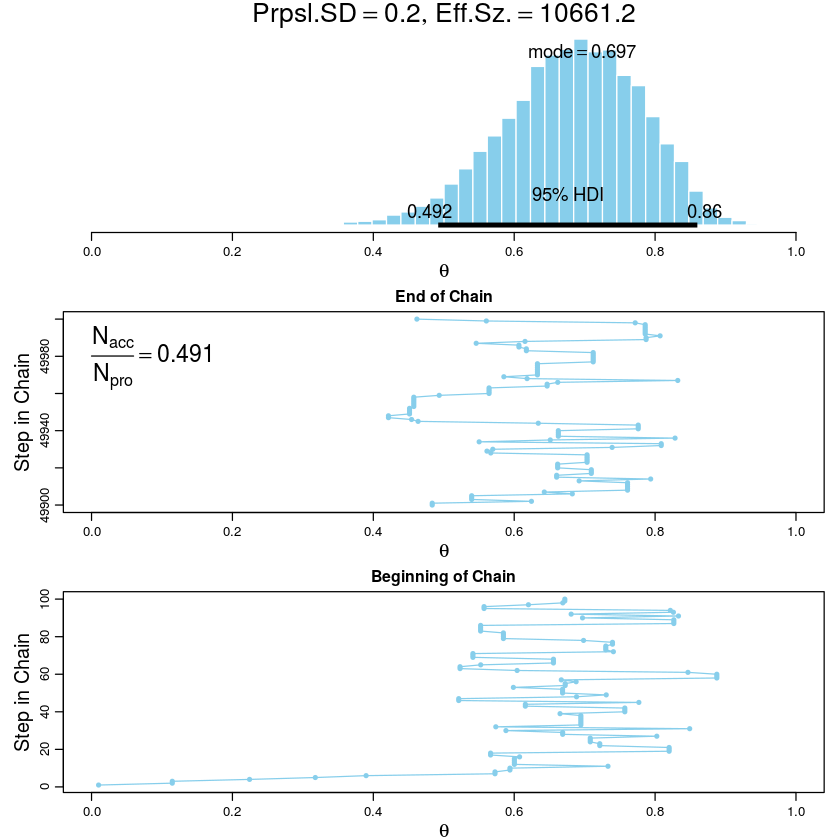

In [7]:
# Now generate the random walk. The 't' index is time or trial in the walk.
# Specify seed to reproduce same random walk:
set.seed(20180401)
# Specify standard deviation of proposal distribution:
proposalSD = c(0.02,0.2,2.0)[2]
for ( t in 1:(trajLength-1) ) {
    currentPosition = trajectory[t]
    # Use the proposal distribution to generate a proposed jump.
    proposedJump = rnorm( 1 , mean=0 , sd=proposalSD )
    # Compute the probability of accepting the proposed jump.
    probAccept = min( 1,
        targetRelProb( currentPosition + proposedJump , myData )
        / targetRelProb( currentPosition , myData ) )
    # Generate a random uniform value from the interval [0,1] to
    # decide whether or not to accept the proposed jump.
    if ( runif(1) < probAccept ) {
        # accept the proposed jump
        trajectory[ t+1 ] = currentPosition + proposedJump
        # increment the accepted counter, just to monitor performance
        if ( t > burnIn ) { nAccepted = nAccepted + 1 }
    } else {
        # reject the proposed jump, stay at current position
        trajectory[ t+1 ] = currentPosition
        # increment the rejected counter, just to monitor performance
        if ( t > burnIn ) { nRejected = nRejected + 1 }
    }
}

# Extract the post-burnIn portion of the trajectory.
acceptedTraj = trajectory[ (burnIn+1) : length(trajectory) ]

# End of Metropolis algorithm.

#-----------------------------------------------------------------------
# Display the chain.
layout( matrix(1:3,nrow=3) )
par(mar=c(3,4,2,1),mgp=c(2,0.7,0))

# Posterior histogram:
paramInfo = plotPost( acceptedTraj , xlim=c(0,1) , xlab=bquote(theta) , 
                      cex.main=2.0 ,
                      main=bquote( list( "Prpsl.SD" == .(proposalSD) ,
                      "Eff.Sz." == .(round(effectiveSize(acceptedTraj),1)) ) ) )

# Trajectory, a.k.a. trace plot, end of chain:
idxToPlot = (trajLength-100):trajLength
plot( trajectory[idxToPlot] , idxToPlot , main="End of Chain" ,
      xlab=bquote(theta) , xlim=c(0,1) , ylab="Step in Chain" ,
      type="o" , pch=20 , col="skyblue" , cex.lab=1.5 )
# Display proposal SD and acceptance ratio in the plot.
text( 0.0 , trajLength , adj=c(0.0,1.1) , cex=1.75 ,
      labels = bquote( frac(N[acc],N[pro]) == 
                       .(signif( nAccepted/length(acceptedTraj) , 3 ))))

# Trajectory, a.k.a. trace plot, beginning of chain:
idxToPlot = 1:100
plot( trajectory[idxToPlot] , idxToPlot , main="Beginning of Chain" ,
      xlab=bquote(theta) , xlim=c(0,1) , ylab="Step in Chain" ,
      type="o" , pch=20 , col="skyblue" , cex.lab=1.5 )
# Indicate burn in limit (might not be visible if not in range):
if ( burnIn > 0 ) {
  abline(h=burnIn,lty="dotted")
  text( 0.5 , burnIn+1 , "Burn In" , adj=c(0.5,1.1) )
}

#### A.

The following lines will be added into the script:

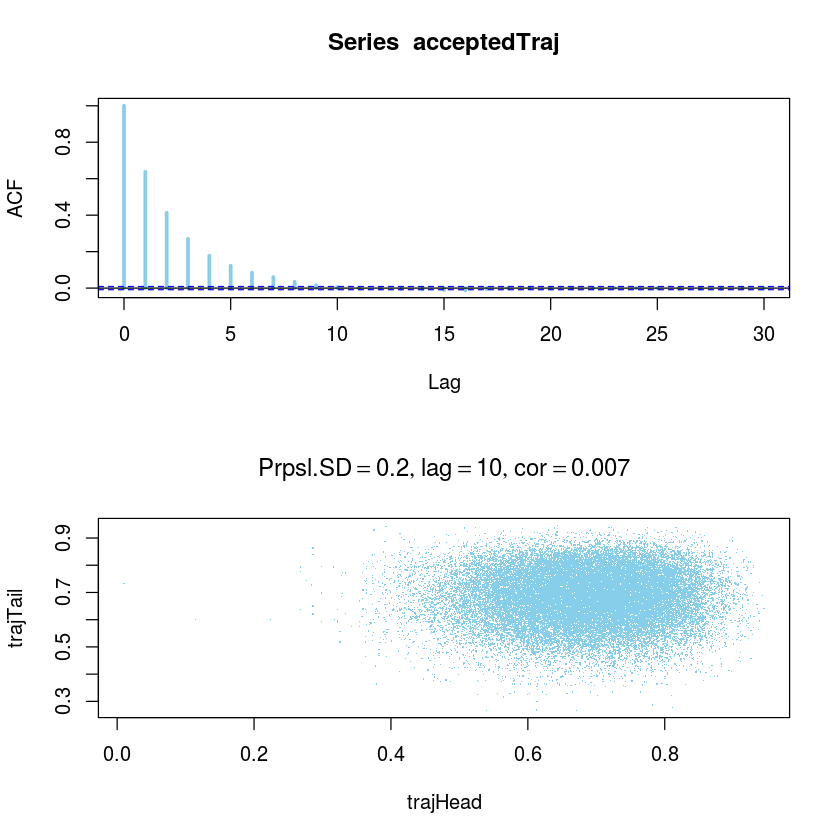

In [11]:
# create an image with two subplots
layout(matrix(1:2,nrow=2))

# calculate the ACF of the accepted trajectory up to a lag of 30
acf( acceptedTraj , lag.max=30 , col="skyblue" , lwd=3 )

# get the length of the plotted ACF
Len = length( acceptedTraj )

# plot values against a lag of 10 to check for autocorrelation significance
Lag = 10
trajHead = acceptedTraj[ 1 : (Len-Lag) ]
trajTail = acceptedTraj[ (1+Lag) : Len ]
plot( trajHead , trajTail , pch="." , col="skyblue" ,
main=bquote( list( "Prpsl.SD" == .(proposalSD) ,
             lag == .(Lag) ,
             cor == .(round(cor(trajHead,trajTail),3)))) )

#### B.

This section of the `BernMetrop.R` code generates a posterior distribution using a standard deviation of 0.02:

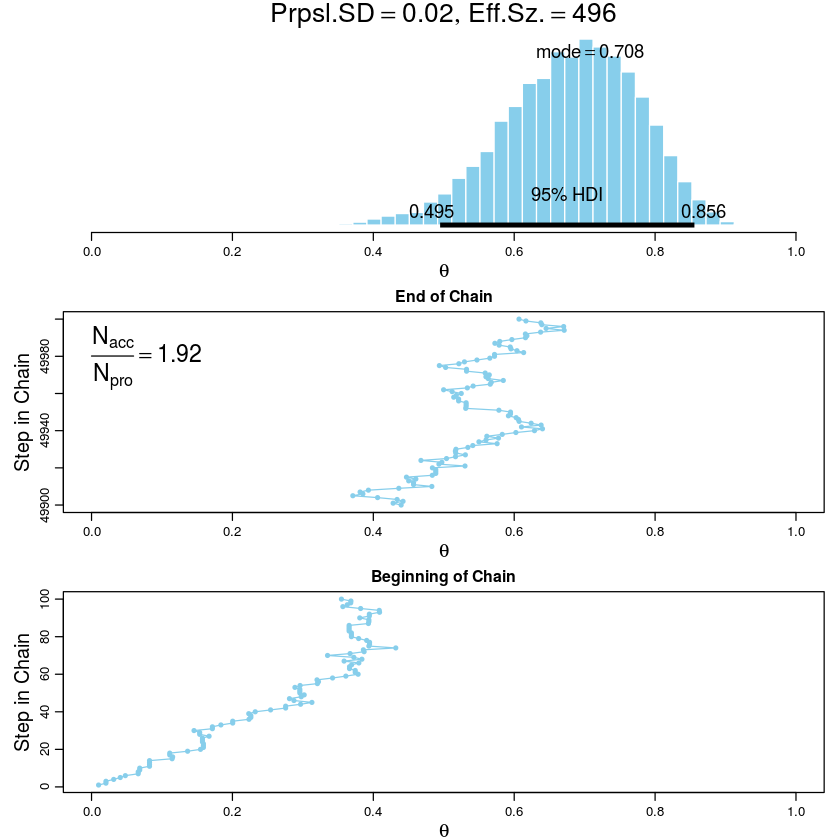

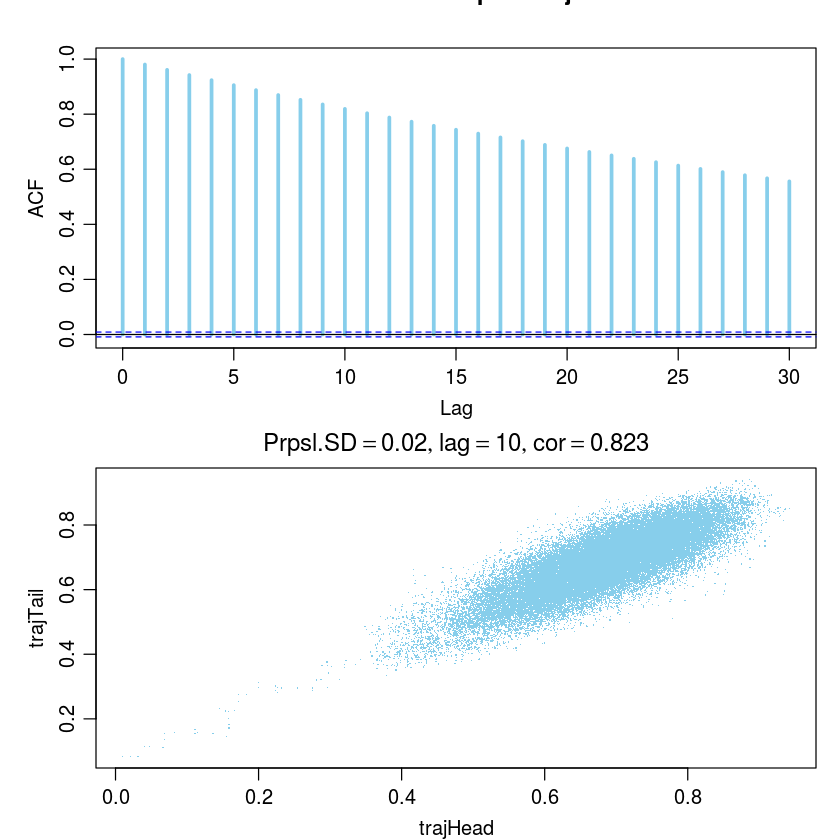

In [13]:
# Now generate the random walk. The 't' index is time or trial in the walk.
# Specify seed to reproduce same random walk:
set.seed(20180401)
# Specify standard deviation of proposal distribution:
proposalSD = c(0.02,0.2,2.0)[1]
for ( t in 1:(trajLength-1) ) {
    currentPosition = trajectory[t]
    # Use the proposal distribution to generate a proposed jump.
    proposedJump = rnorm( 1 , mean=0 , sd=proposalSD )
    # Compute the probability of accepting the proposed jump.
    probAccept = min( 1,
        targetRelProb( currentPosition + proposedJump , myData )
        / targetRelProb( currentPosition , myData ) )
    # Generate a random uniform value from the interval [0,1] to
    # decide whether or not to accept the proposed jump.
    if ( runif(1) < probAccept ) {
        # accept the proposed jump
        trajectory[ t+1 ] = currentPosition + proposedJump
        # increment the accepted counter, just to monitor performance
        if ( t > burnIn ) { nAccepted = nAccepted + 1 }
    } else {
        # reject the proposed jump, stay at current position
        trajectory[ t+1 ] = currentPosition
        # increment the rejected counter, just to monitor performance
        if ( t > burnIn ) { nRejected = nRejected + 1 }
    }
}

# Extract the post-burnIn portion of the trajectory.
acceptedTraj = trajectory[ (burnIn+1) : length(trajectory) ]

# End of Metropolis algorithm.

#-----------------------------------------------------------------------
# Display the chain.
layout( matrix(1:3,nrow=3) )
par(mar=c(3,4,2,1),mgp=c(2,0.7,0))

# Posterior histogram:
paramInfo = plotPost( acceptedTraj , xlim=c(0,1) , xlab=bquote(theta) , 
                      cex.main=2.0 ,
                      main=bquote( list( "Prpsl.SD" == .(proposalSD) ,
                      "Eff.Sz." == .(round(effectiveSize(acceptedTraj),1)) ) ) )

# Trajectory, a.k.a. trace plot, end of chain:
idxToPlot = (trajLength-100):trajLength
plot( trajectory[idxToPlot] , idxToPlot , main="End of Chain" ,
      xlab=bquote(theta) , xlim=c(0,1) , ylab="Step in Chain" ,
      type="o" , pch=20 , col="skyblue" , cex.lab=1.5 )
# Display proposal SD and acceptance ratio in the plot.
text( 0.0 , trajLength , adj=c(0.0,1.1) , cex=1.75 ,
      labels = bquote( frac(N[acc],N[pro]) == 
                       .(signif( nAccepted/length(acceptedTraj) , 3 ))))

# Trajectory, a.k.a. trace plot, beginning of chain:
idxToPlot = 1:100
plot( trajectory[idxToPlot] , idxToPlot , main="Beginning of Chain" ,
      xlab=bquote(theta) , xlim=c(0,1) , ylab="Step in Chain" ,
      type="o" , pch=20 , col="skyblue" , cex.lab=1.5 )
# Indicate burn in limit (might not be visible if not in range):
if ( burnIn > 0 ) {
  abline(h=burnIn,lty="dotted")
  text( 0.5 , burnIn+1 , "Burn In" , adj=c(0.5,1.1) )
}

# create an image with two subplots
layout(matrix(1:2,nrow=2))

# calculate the ACF of the accepted trajectory up to a lag of 30
acf( acceptedTraj , lag.max=30 , col="skyblue" , lwd=3 )

# get the length of the plotted ACF
Len = length( acceptedTraj )

# plot values against a lag of 10 to check for autocorrelation significance
Lag = 10
trajHead = acceptedTraj[ 1 : (Len-Lag) ]
trajTail = acceptedTraj[ (1+Lag) : Len ]
plot( trajHead , trajTail , pch="." , col="skyblue" ,
main=bquote( list( "Prpsl.SD" == .(proposalSD) ,
             lag == .(Lag) ,
             cor == .(round(cor(trajHead,trajTail),3)))) )

This section of the `BernMetrop.R` code generates a posterior distribution using a standard deviation of 0.2:

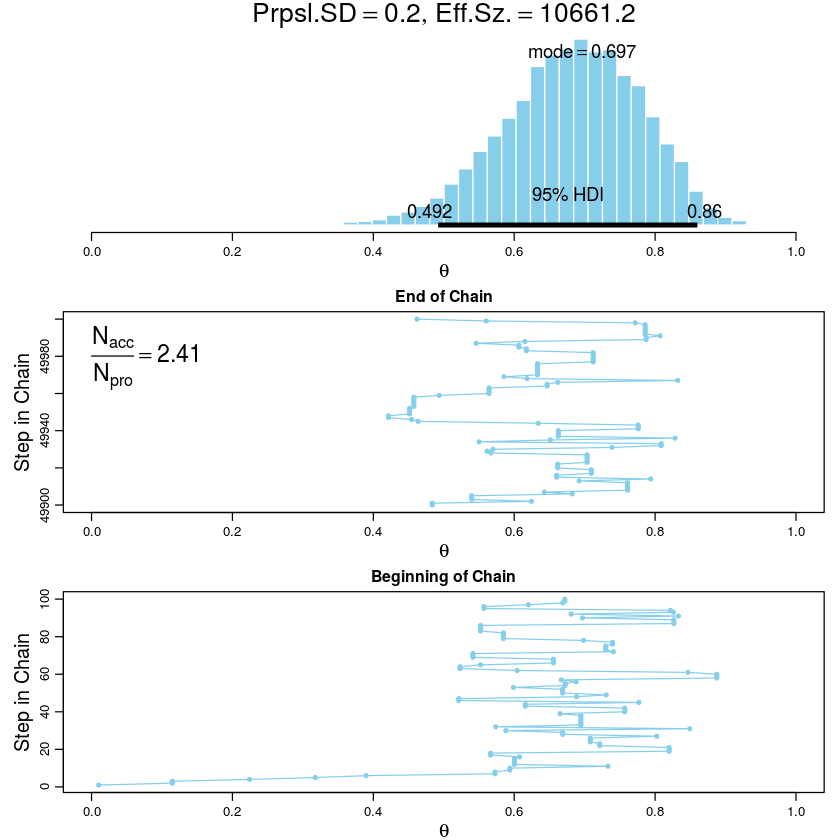

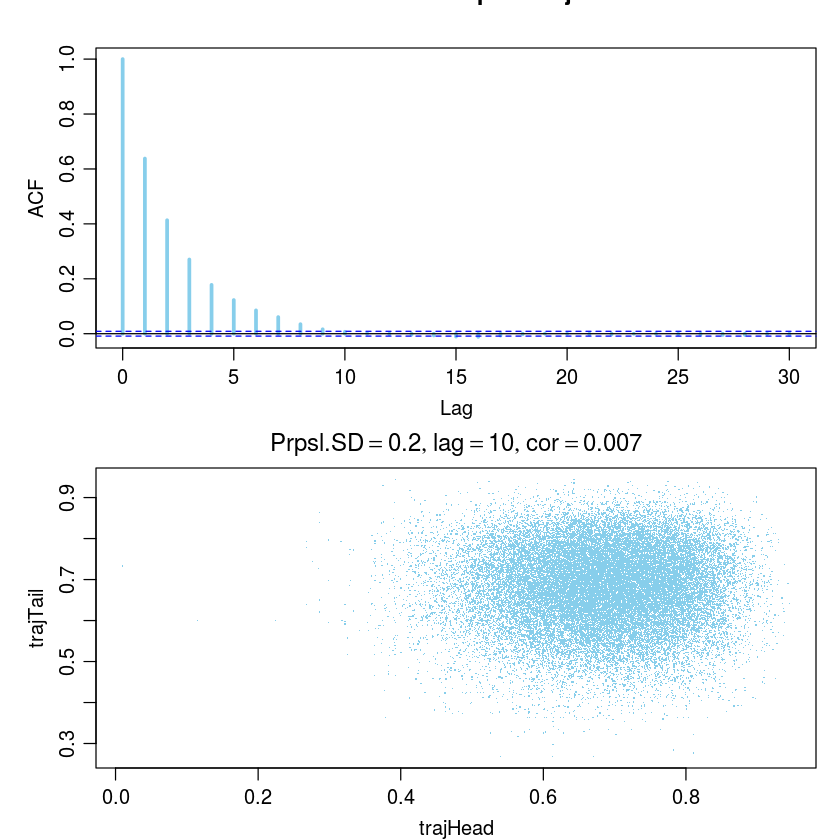

In [14]:
# Now generate the random walk. The 't' index is time or trial in the walk.
# Specify seed to reproduce same random walk:
set.seed(20180401)
# Specify standard deviation of proposal distribution:
proposalSD = c(0.02,0.2,2.0)[2]
for ( t in 1:(trajLength-1) ) {
    currentPosition = trajectory[t]
    # Use the proposal distribution to generate a proposed jump.
    proposedJump = rnorm( 1 , mean=0 , sd=proposalSD )
    # Compute the probability of accepting the proposed jump.
    probAccept = min( 1,
        targetRelProb( currentPosition + proposedJump , myData )
        / targetRelProb( currentPosition , myData ) )
    # Generate a random uniform value from the interval [0,1] to
    # decide whether or not to accept the proposed jump.
    if ( runif(1) < probAccept ) {
        # accept the proposed jump
        trajectory[ t+1 ] = currentPosition + proposedJump
        # increment the accepted counter, just to monitor performance
        if ( t > burnIn ) { nAccepted = nAccepted + 1 }
    } else {
        # reject the proposed jump, stay at current position
        trajectory[ t+1 ] = currentPosition
        # increment the rejected counter, just to monitor performance
        if ( t > burnIn ) { nRejected = nRejected + 1 }
    }
}

# Extract the post-burnIn portion of the trajectory.
acceptedTraj = trajectory[ (burnIn+1) : length(trajectory) ]

# End of Metropolis algorithm.

#-----------------------------------------------------------------------
# Display the chain.
layout( matrix(1:3,nrow=3) )
par(mar=c(3,4,2,1),mgp=c(2,0.7,0))

# Posterior histogram:
paramInfo = plotPost( acceptedTraj , xlim=c(0,1) , xlab=bquote(theta) , 
                      cex.main=2.0 ,
                      main=bquote( list( "Prpsl.SD" == .(proposalSD) ,
                      "Eff.Sz." == .(round(effectiveSize(acceptedTraj),1)) ) ) )

# Trajectory, a.k.a. trace plot, end of chain:
idxToPlot = (trajLength-100):trajLength
plot( trajectory[idxToPlot] , idxToPlot , main="End of Chain" ,
      xlab=bquote(theta) , xlim=c(0,1) , ylab="Step in Chain" ,
      type="o" , pch=20 , col="skyblue" , cex.lab=1.5 )
# Display proposal SD and acceptance ratio in the plot.
text( 0.0 , trajLength , adj=c(0.0,1.1) , cex=1.75 ,
      labels = bquote( frac(N[acc],N[pro]) == 
                       .(signif( nAccepted/length(acceptedTraj) , 3 ))))

# Trajectory, a.k.a. trace plot, beginning of chain:
idxToPlot = 1:100
plot( trajectory[idxToPlot] , idxToPlot , main="Beginning of Chain" ,
      xlab=bquote(theta) , xlim=c(0,1) , ylab="Step in Chain" ,
      type="o" , pch=20 , col="skyblue" , cex.lab=1.5 )
# Indicate burn in limit (might not be visible if not in range):
if ( burnIn > 0 ) {
  abline(h=burnIn,lty="dotted")
  text( 0.5 , burnIn+1 , "Burn In" , adj=c(0.5,1.1) )
}

# create an image with two subplots
layout(matrix(1:2,nrow=2))

# calculate the ACF of the accepted trajectory up to a lag of 30
acf( acceptedTraj , lag.max=30 , col="skyblue" , lwd=3 )

# get the length of the plotted ACF
Len = length( acceptedTraj )

# plot values against a lag of 10 to check for autocorrelation significance
Lag = 10
trajHead = acceptedTraj[ 1 : (Len-Lag) ]
trajTail = acceptedTraj[ (1+Lag) : Len ]
plot( trajHead , trajTail , pch="." , col="skyblue" ,
main=bquote( list( "Prpsl.SD" == .(proposalSD) ,
             lag == .(Lag) ,
             cor == .(round(cor(trajHead,trajTail),3)))) )

This section of the `BernMetrop.R` code generates a posterior distribution using a standard deviation of 2.0:

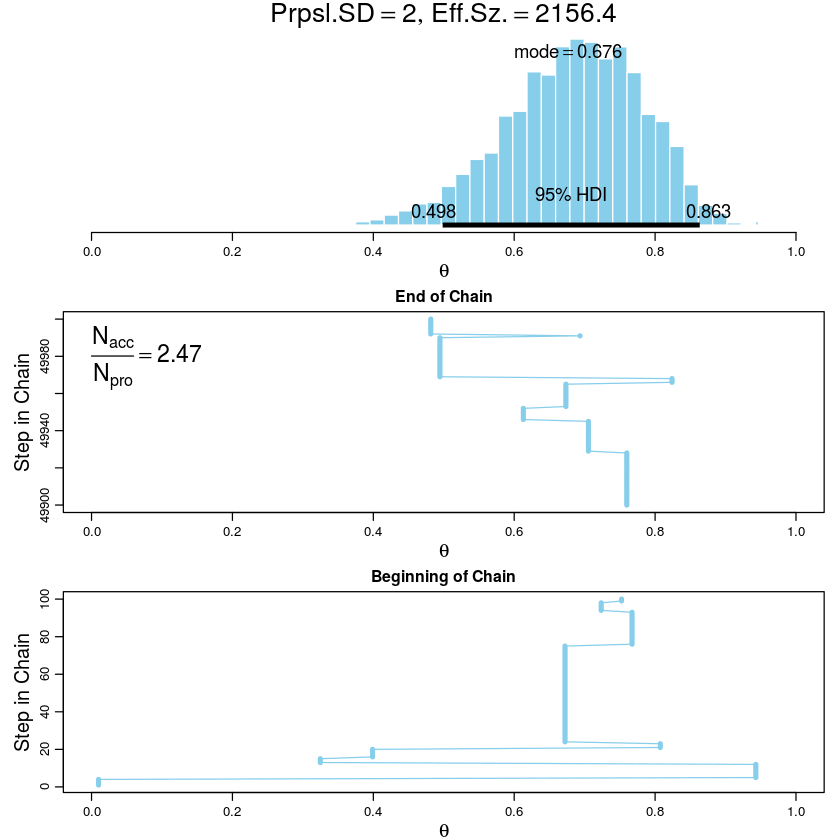

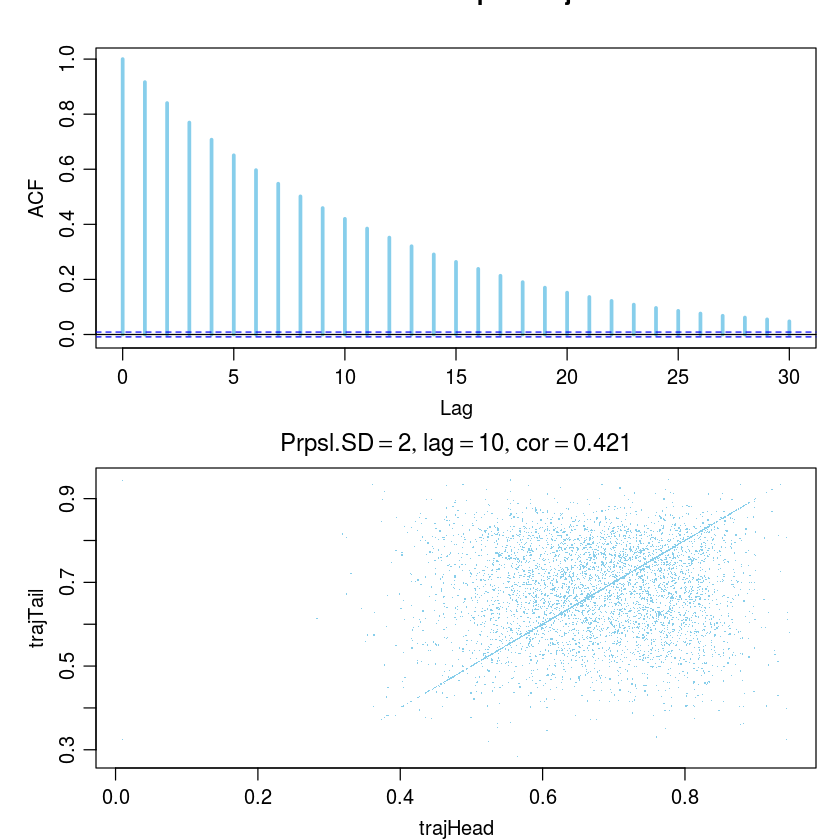

In [15]:
# Now generate the random walk. The 't' index is time or trial in the walk.
# Specify seed to reproduce same random walk:
set.seed(20180401)
# Specify standard deviation of proposal distribution:
proposalSD = c(0.02,0.2,2.0)[3]
for ( t in 1:(trajLength-1) ) {
    currentPosition = trajectory[t]
    # Use the proposal distribution to generate a proposed jump.
    proposedJump = rnorm( 1 , mean=0 , sd=proposalSD )
    # Compute the probability of accepting the proposed jump.
    probAccept = min( 1,
        targetRelProb( currentPosition + proposedJump , myData )
        / targetRelProb( currentPosition , myData ) )
    # Generate a random uniform value from the interval [0,1] to
    # decide whether or not to accept the proposed jump.
    if ( runif(1) < probAccept ) {
        # accept the proposed jump
        trajectory[ t+1 ] = currentPosition + proposedJump
        # increment the accepted counter, just to monitor performance
        if ( t > burnIn ) { nAccepted = nAccepted + 1 }
    } else {
        # reject the proposed jump, stay at current position
        trajectory[ t+1 ] = currentPosition
        # increment the rejected counter, just to monitor performance
        if ( t > burnIn ) { nRejected = nRejected + 1 }
    }
}

# Extract the post-burnIn portion of the trajectory.
acceptedTraj = trajectory[ (burnIn+1) : length(trajectory) ]

# End of Metropolis algorithm.

#-----------------------------------------------------------------------
# Display the chain.
layout( matrix(1:3,nrow=3) )
par(mar=c(3,4,2,1),mgp=c(2,0.7,0))

# Posterior histogram:
paramInfo = plotPost( acceptedTraj , xlim=c(0,1) , xlab=bquote(theta) , 
                      cex.main=2.0 ,
                      main=bquote( list( "Prpsl.SD" == .(proposalSD) ,
                      "Eff.Sz." == .(round(effectiveSize(acceptedTraj),1)) ) ) )

# Trajectory, a.k.a. trace plot, end of chain:
idxToPlot = (trajLength-100):trajLength
plot( trajectory[idxToPlot] , idxToPlot , main="End of Chain" ,
      xlab=bquote(theta) , xlim=c(0,1) , ylab="Step in Chain" ,
      type="o" , pch=20 , col="skyblue" , cex.lab=1.5 )
# Display proposal SD and acceptance ratio in the plot.
text( 0.0 , trajLength , adj=c(0.0,1.1) , cex=1.75 ,
      labels = bquote( frac(N[acc],N[pro]) == 
                       .(signif( nAccepted/length(acceptedTraj) , 3 ))))

# Trajectory, a.k.a. trace plot, beginning of chain:
idxToPlot = 1:100
plot( trajectory[idxToPlot] , idxToPlot , main="Beginning of Chain" ,
      xlab=bquote(theta) , xlim=c(0,1) , ylab="Step in Chain" ,
      type="o" , pch=20 , col="skyblue" , cex.lab=1.5 )
# Indicate burn in limit (might not be visible if not in range):
if ( burnIn > 0 ) {
  abline(h=burnIn,lty="dotted")
  text( 0.5 , burnIn+1 , "Burn In" , adj=c(0.5,1.1) )
}

# create an image with two subplots
layout(matrix(1:2,nrow=2))

# calculate the ACF of the accepted trajectory up to a lag of 30
acf( acceptedTraj , lag.max=30 , col="skyblue" , lwd=3 )

# get the length of the plotted ACF
Len = length( acceptedTraj )

# plot values against a lag of 10 to check for autocorrelation significance
Lag = 10
trajHead = acceptedTraj[ 1 : (Len-Lag) ]
trajTail = acceptedTraj[ (1+Lag) : Len ]
plot( trajHead , trajTail , pch="." , col="skyblue" ,
main=bquote( list( "Prpsl.SD" == .(proposalSD) ,
             lag == .(Lag) ,
             cor == .(round(cor(trajHead,trajTail),3)))) )

The resulting chains from all three proposal distributions seem to match those found in figure 7.4.

For posterior distributions which are drastically different from their proposal distributions, there is a significant amount of autocorrelation. Proposal distributions with standard deviations of 0.02 and 2.0 have, respectively, ACF values of 0.823 and 0.421 at lag 10, both of which are very significant.

For the proposal distribution with a standard deviation of 0.2, there is an autocorrelation value of 0.007 at lag 10, which is not significant. Even with this one though, there is evidence of autocorrelation within the first few lags, meaning that a better standard deviation could be found.

#### C.

The dense line of points in the lag plot for the proposal distribution with a standard deviation of 2.0 indicates that many of the values are the same as they were 10 steps ago. It indicates substantial autocorrelation and a pretty inefficient state for MCMC estimation.